# Exploring AirBnB in Athens

In this assignment we will be performing an analysis on AirBnB in Athens using the data collected by [Inside AirBnB](http://insideairbnb.com).

## Neighbourhood Listings in Descending Order

For starters, we need to import some of the main packages we'll need. 

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Now we may start by reading the first .csv we will be using, the [listings.csv](listings.csv).

In [18]:
import zipfile

with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [19]:
listings = pd.read_csv("listings.csv")

We use the `neighbourhood_cleansed` column which refers to the neighbourhoods' names to get the number of listings per neighbourhood and after that we plot it.

Text(0, 0.5, 'Neighbourhoods')

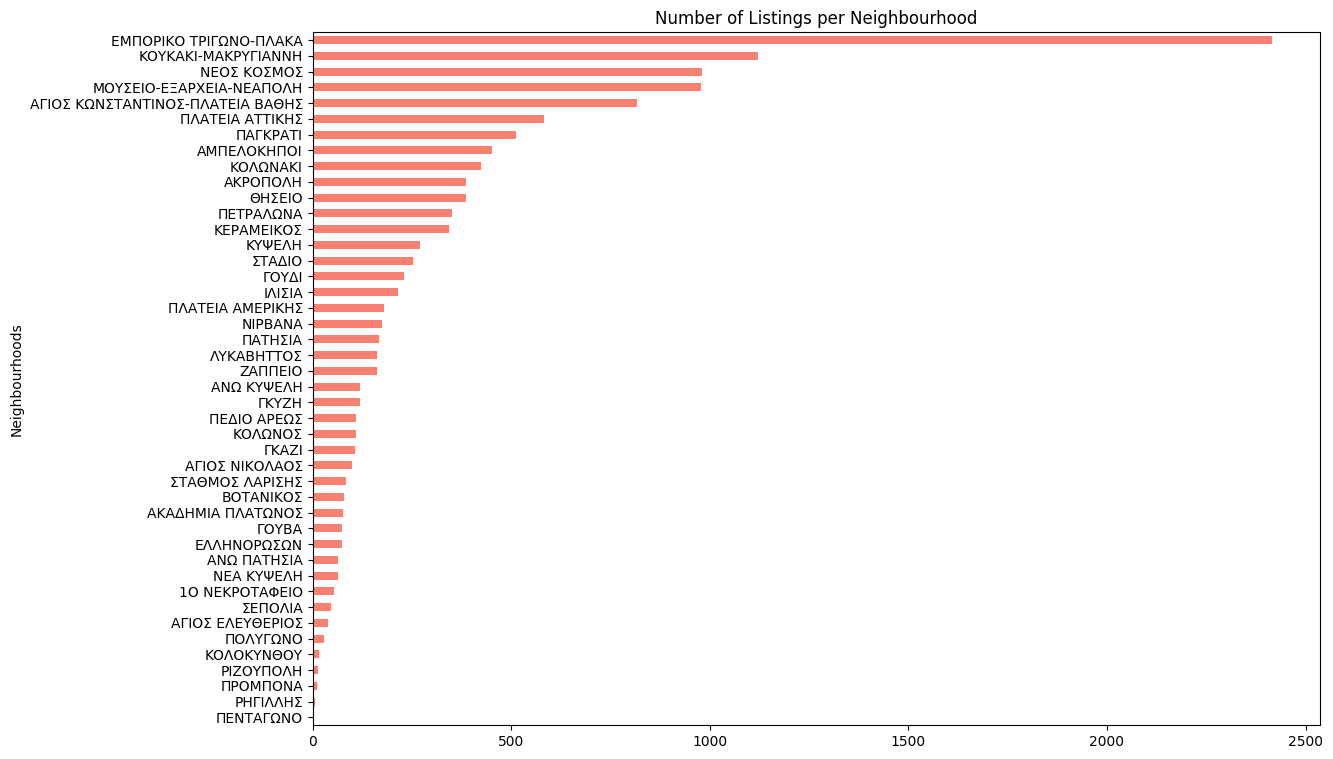

In [20]:
listings_per_neighbourhood = listings['neighbourhood_cleansed'].value_counts().to_frame('Count')
listings_per_neighbourhood.sort_values('Count',inplace=True)
_ = listings_per_neighbourhood.plot(kind='barh', figsize=(13, 9), color='salmon', title='Number of Listings per Neighbourhood', legend=False)
plt.ylabel('Neighbourhoods')

As we see `ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ` has by far the most listings in Athens, almost double than `ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ`which comes second.

## Neighbourhood Prices in Descending Order

In order to create the table we'll be using the `neighbourhood_cleansed` and the `price` columns.

In [21]:
# Turn the price column from string to float to perform calculations
listings['price'] = listings['price'].str.replace('[\$,]', '', regex=True).astype(float)

neighbourhood_prices = pd.concat([listings['neighbourhood_cleansed'], listings['price']], axis=1)

At this point, it's much needed to examine the price data for possible outliers.

In [22]:
neighbourhood_prices.describe()

,price
count,12955.000000
mean,110.458587
std,738.185656
min,10.000000
25%,50.000000
50%,71.000000
75%,113.000000
max,80275.000000


And thank goodness we did because 80275€ for a night is kind of outrageous...

In [23]:
listings.nlargest(1, 'price')

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
3641,32463338,https://www.airbnb.com/rooms/32463338,20230921043851,2023-09-21,city scrape,Rental unit in Athina · ★4.77 · 2 bedrooms · 3...,ΕΧΤΡΑ<br /><br /><b>Other things to note</b><b...,NaN,https://a0.muscache.com/pictures/a07e8bdb-2c92...,217615215,...,4.87,4.47,4.67,00000555835,t,5,5,0,0,0.55


* If we follow the `listing_url` we notice that there's indeed something wrong with the listing; it doesn't seem availiable for booking any time soon.
* So it's pretty safe to assume that that's what caused the price to skyrocket.
* And that's why we could make an assuption that any of the listings that aren't available for the next 30, 60 and 90 days were most likely unavailable the day of the scraping and hence their price should not be taken into consideration.

In [24]:
neighbourhood_prices = neighbourhood_prices[(listings['availability_30'] > 0) & (listings['availability_60'] > 0) & (listings['availability_90'] > 0)]
neighbourhood_prices.describe()

,price
count,10292.000000
mean,101.944617
std,104.392155
min,10.000000
25%,51.000000
50%,75.000000
75%,117.000000
max,2500.000000


Now our results seem much more realistic!

In [25]:
neighbourhood_stats = neighbourhood_prices.groupby('neighbourhood_cleansed').agg({'price': ['median', 'mean', 'std','count']}).reset_index()
neighbourhood_stats.columns = ['neighbourhoods', 'median price', 'average price', 'standard deviation','total number']
neighbourhood_stats.set_index('neighbourhoods', inplace=True)
neighbourhood_stats.sort_values(by='median price', ascending=False)

,median price,average price,standard deviation,total number
neighbourhoods,,,,
ΡΗΓΙΛΛΗΣ,120.0,367.800000,578.622675,5
ΖΑΠΠΕΙΟ,114.5,179.555556,180.796636,144
ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ,104.0,130.965264,109.807152,2044
ΚΟΛΩΝΑΚΙ,102.0,129.415430,93.040791,337
ΑΚΡΟΠΟΛΗ,100.0,141.319489,135.821221,313
ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ,95.5,125.278826,108.744962,954
ΘΗΣΕΙΟ,95.0,126.719626,99.737543,321
ΚΕΡΑΜΕΙΚΟΣ,90.0,125.493333,133.878707,300
ΛΥΚΑΒΗΤΤΟΣ,75.0,104.782258,86.241254,124


## Availability per Day

For this plot we'll use the `matplotlib.dates` package to make the $x$ axis more appealable.

In [26]:
import matplotlib.dates as mdates

We'll read the [calendar.csv](calendar.csv).

In [27]:
calendar = pd.read_csv("calendar.csv")

# Count the available dates for all listings
availabilities = calendar[calendar['available'] == 't'].groupby('date')['available'].count().reset_index()
availabilities.columns = ['date', 'count_of_available']
availabilities['date'] = pd.to_datetime(availabilities['date'])

And now time for the plot...

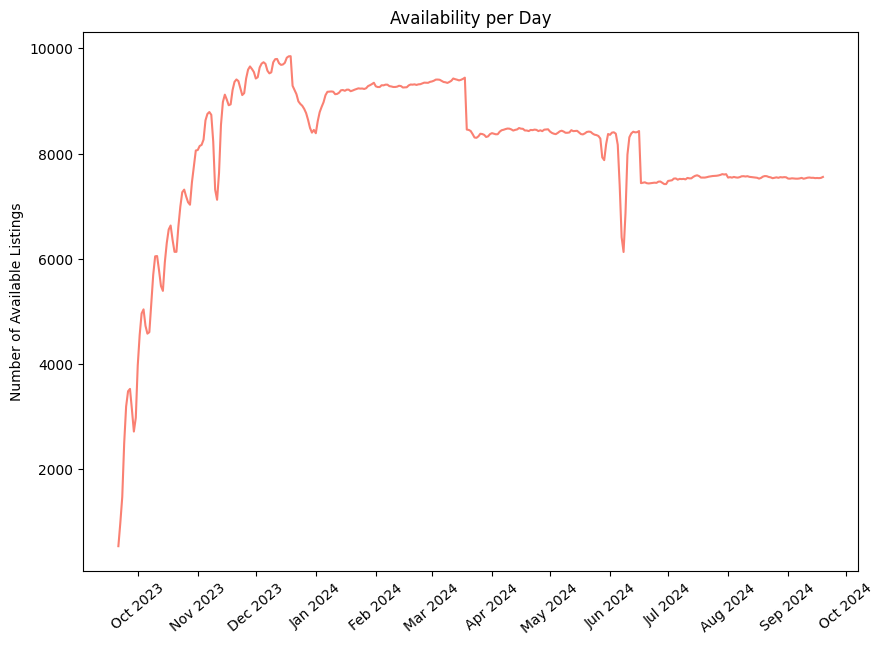

In [28]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(availabilities['date'], availabilities['count_of_available'], color='salmon')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.ylabel('Number of Available Listings')
plt.title('Availability per Day')
# Rotate the x-axis labels for better readability
plt.xticks(rotation=40)

plt.show()

It's quite what we expected since the closer the date to now the more unavailable listings for the next 3 months.

After that we can see 4 low points: 1 around the 17th of November (Polytechneio), 1 around Christmas, 1 around Easter and an even bigger one around June for summer. Seems like some people are really planning ahead!

We also notice lots of local minimums. One thought could be that that's because of the weekends.

<Axes: xlabel='date'>

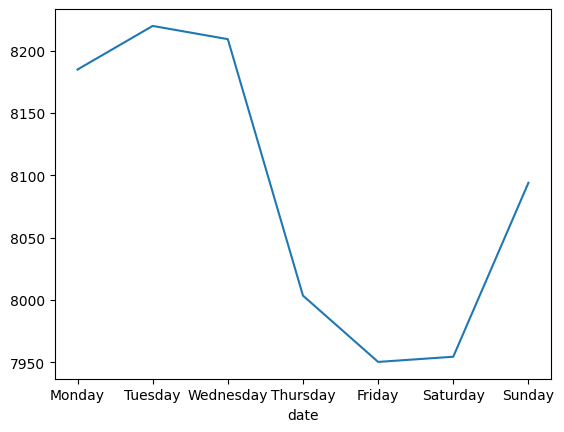

In [29]:
availabilities['date'] = availabilities['date'].dt.day_name()
day_order = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
availabilities.groupby('date').agg({'count_of_available': ['mean']}).reindex(day_order).plot(legend=False)

Although the difference between 8200 and 7950 is pretty small it is possible that this is the reason behind local minimums indeed.

## Reviews, Occupacy per Listing, Average Income


First, we're going to create a histogram showing the number of reviews per listing. The histogram bins the number of reviews, from the smallest to the maximum rounded up to the closest hundred.

In [30]:
reviews_per_listing = listings[['id', 'number_of_reviews']].sort_values(by='number_of_reviews', ascending=True)
reviews_per_listing.describe()

,id,number_of_reviews
count,1.295500e+04,12955.000000
mean,3.450556e+17,48.674489
std,4.025301e+17,83.281705
min,1.059500e+04,0.000000
25%,3.031469e+07,2.000000
50%,5.096457e+07,13.000000
75%,7.823914e+17,56.000000
max,9.842893e+17,865.000000


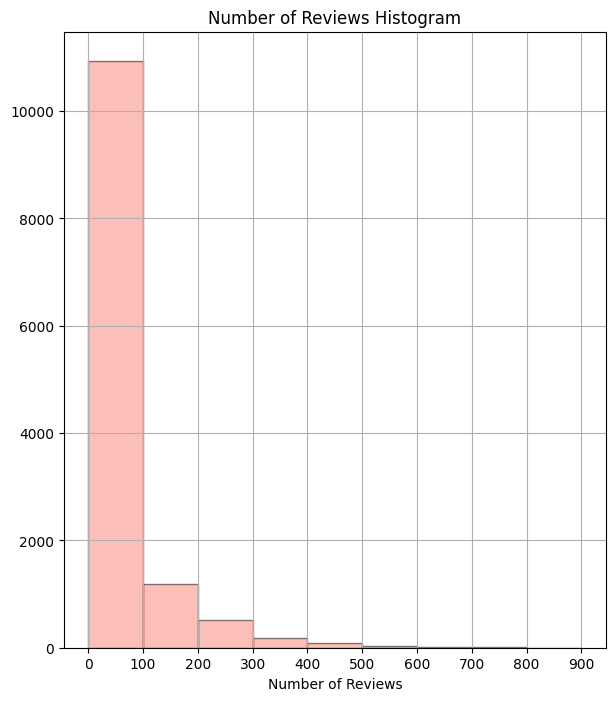

In [31]:
_ = reviews_per_listing.number_of_reviews.hist(bins=np.linspace(0, 900, 10),
                             color='salmon', edgecolor='black', 
                             alpha=0.5, figsize=(7, 8))

xticks = np.linspace(0, 900, 10)
xtick_labels = [str(int(val)) for val in xticks]

plt.title('Number of Reviews Histogram')
plt.xlabel('Number of Reviews') 
_ = plt.xticks(xticks, xtick_labels)

Again, as expected most listings are on the first bin, but we definetely have some cases with 300+ reviews (goes up to 865 as we saw).

* Now in order to calculate the average occupacy per listing per month, we will find the average reviews per month and assume that half of the bookings result in reviews.
* Since we want the result to show the current reality we're interested in the reviews that happened in 2023, not older ones.
* So we'll read the [reviews.csv](reviews.csv) and count only these reviews.

In [32]:
reviews = pd.read_csv('reviews.csv')

reviews['date'] = pd.to_datetime(reviews['date'])
reviews_per_listing = reviews[reviews['date'] >= pd.to_datetime('2022-10-30')].groupby('listing_id').size().reset_index(name='number_of_reviews')
reviews_per_listing.describe()

,listing_id,number_of_reviews
count,9.367000e+03,9367.000000
mean,3.565189e+17,16.735561
std,3.999175e+17,18.584433
min,1.059500e+04,1.000000
25%,3.185151e+07,3.000000
50%,5.185217e+07,9.000000
75%,7.840301e+17,24.000000
max,9.795963e+17,179.000000


Seems alright! So we may continue.

In [33]:
reviews_per_listing_per_month = (reviews_per_listing['number_of_reviews']/12)

average_occupacy =  reviews_per_listing_per_month * 2

We also assume that each booking is for a three nights stay in order to calculate the average income per month.

In [34]:
average_bookings = average_occupacy * 3
average_bookings.describe()

count    9367.000000
mean        8.367781
std         9.292217
min         0.500000
25%         1.500000
50%         4.500000
75%        12.000000
max        89.500000
Name: number_of_reviews, dtype: float64

Kind of hard to be booked for 89.5 days out of 30 per month hm. Seems like its time for some housecleaning. We'll be using the IQR method.

In [35]:
Q3 = average_bookings.quantile(0.75)
Q1 = average_bookings.quantile(0.75)
IQR = Q3 - Q1

average_bookings = np.where(average_bookings > Q1-1.5*IQR, Q1-1.5*IQR, average_bookings)

In [36]:
# Turn the price column from string to float to perform calculations
calendar['price'] = calendar['price'].str.replace('[$,]', '', regex=True).astype(float)

calendar.describe()

,listing_id,price,minimum_nights,maximum_nights
count,4.728229e+06,4.728229e+06,4.728229e+06,4.728229e+06
mean,3.450809e+17,1.418523e+02,3.450921e+00,7.988898e+02
std,4.025185e+17,7.994942e+02,1.851076e+01,4.360061e+02
min,1.059500e+04,0.000000e+00,1.000000e+00,1.000000e+00
25%,3.031469e+07,5.000000e+01,1.000000e+00,3.650000e+02
50%,5.096457e+07,7.100000e+01,2.000000e+00,1.125000e+03
75%,7.824274e+17,1.170000e+02,2.000000e+00,1.125000e+03
max,9.842893e+17,8.514000e+04,8.000000e+02,4.444000e+03


Some housecleaning again...

In [37]:
Q1 = calendar['price'].quantile(0.25)
Q3 = calendar['price'].quantile(0.75)
IQR = Q3-Q1


calendar['price'] = np.where(calendar['price'] < Q1-1.5*IQR, Q1-1.5*IQR, calendar['price'])
calendar['price'] = np.where(calendar['price'] > Q3+1.5*IQR, Q3+1.5*IQR, calendar['price'])
calendar.describe()

,listing_id,price,minimum_nights,maximum_nights
count,4.728229e+06,4.728229e+06,4.728229e+06,4.728229e+06
mean,3.450809e+17,8.993405e+01,3.450921e+00,7.988898e+02
std,4.025185e+17,5.475253e+01,1.851076e+01,4.360061e+02
min,1.059500e+04,0.000000e+00,1.000000e+00,1.000000e+00
25%,3.031469e+07,5.000000e+01,1.000000e+00,3.650000e+02
50%,5.096457e+07,7.100000e+01,2.000000e+00,1.125000e+03
75%,7.824274e+17,1.170000e+02,2.000000e+00,1.125000e+03
max,9.842893e+17,2.175000e+02,8.000000e+02,4.444000e+03


Looking good.

In [38]:
average_income_per_month = average_bookings.mean() * calendar['price'].mean()
average_income_per_month 

529.9503112576085

At least the minimum wage is more than that.

## Listings per Room Type

We'll be showing the number of listings per room type, in absolute numbers, and also in percentages (the percentage of listings for each particular room type).

In [39]:
room_types = listings.groupby('room_type').agg({'room_type': ['count']}).reset_index()
room_types.columns = ['type', 'count']
room_types['percentages'] = (room_types['count'] / listings.shape[0] * 100).round(1)
room_types = room_types.sort_values(by='count', ascending=False)

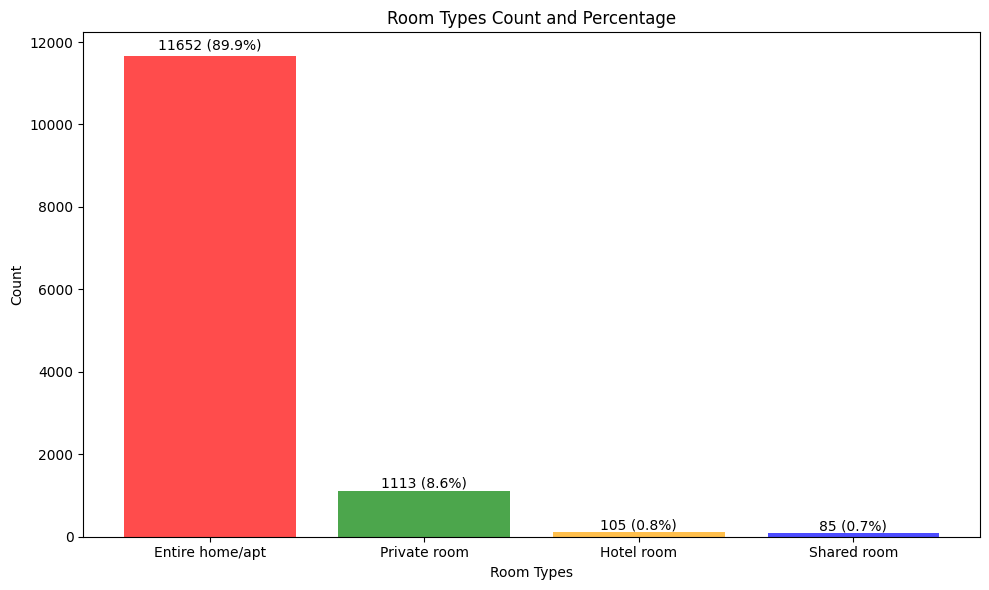

In [40]:
plt.figure(figsize=(10, 6))  # Set the figure size

colors = ['red', 'green', 'orange', 'blue']

plt.bar(room_types['type'], room_types['count'], label='Count', alpha=0.7, color=colors)  # Bars for count
plt.xlabel('Room Types')
plt.ylabel('Count')
plt.title('Room Types Count and Percentage')

for i, (count, percentage) in enumerate(zip(room_types['count'], room_types['percentages'])):
    plt.text(i, count + percentage, f'{count} ({percentage}%)', ha='center', va='bottom')

# Show the bar chart
plt.tight_layout()
plt.show()

It would be also interesting to show the number of listings per neighrbourhood and room type.

In [41]:
room_types_per_neighbourhood = listings.groupby(['neighbourhood_cleansed', 'room_type']).agg({'room_type': ['count']}).reset_index()
room_types_per_neighbourhood.columns = ['neighbourhoods','type', 'count']
room_types_per_neighbourhood = pd.pivot_table(room_types_per_neighbourhood, values='count', index=['neighbourhoods'], columns=['type'], aggfunc="sum").fillna(0)

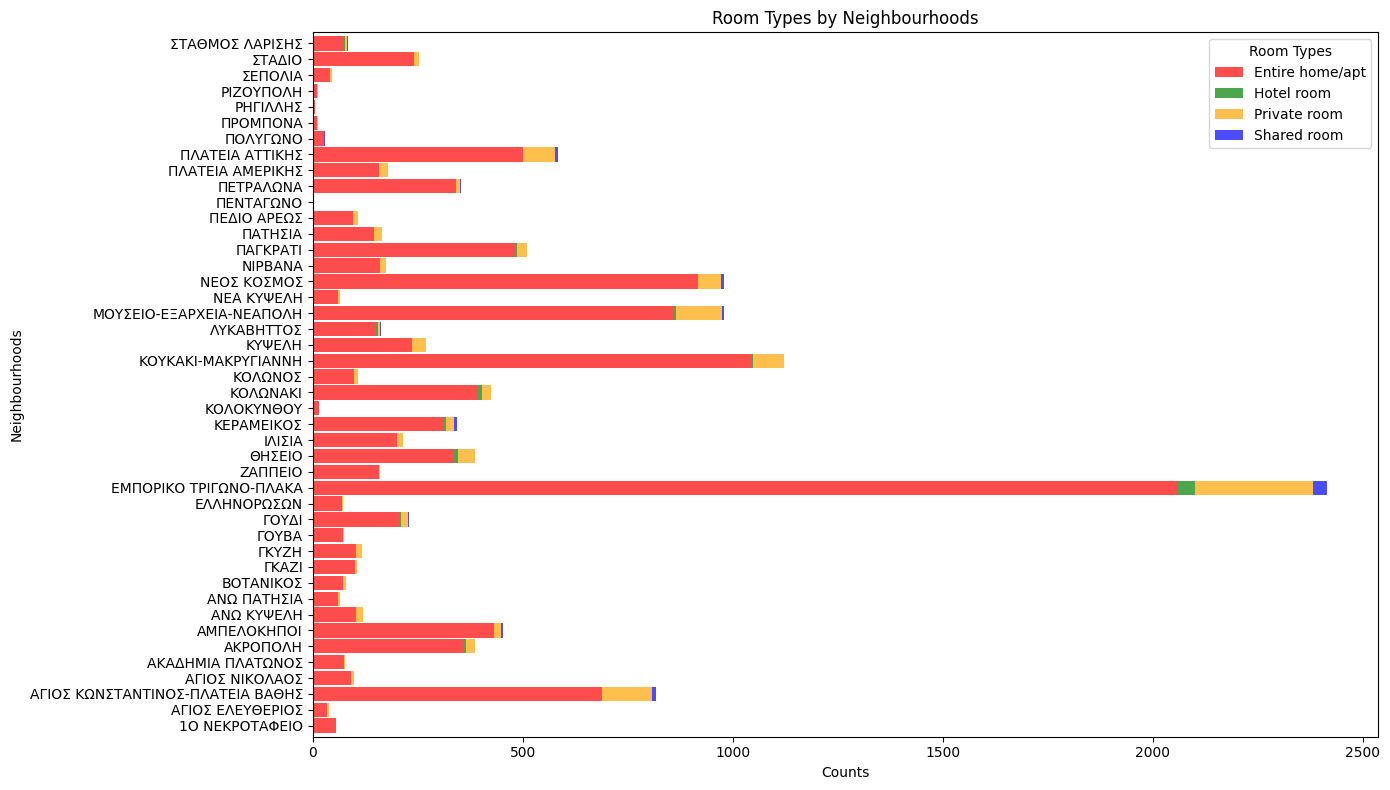

In [42]:
room_types_per_neighbourhood.plot(kind='barh', stacked=True, alpha=0.7, width=0.9, figsize=(14, 8), color=colors)

plt.ylabel('Neighbourhoods')
plt.xlabel('Counts')
plt.title('Room Types by Neighbourhoods')
plt.legend(title='Room Types', loc='upper right')

plt.tight_layout()
plt.show()

Lots and lots of entire home/apts in every neighbourhood.

## Prices per Day

We'll start by creating a table with the average price per listing per day.

In [43]:
price_per_day = calendar.groupby('date').agg({'price': ['mean']}).reset_index()
price_per_day

,date,price
,,mean
0,2023-09-21,89.790721
1,2023-09-22,91.576424
2,2023-09-23,91.729080
3,2023-09-24,89.749460
4,2023-09-25,89.030184
...,...,...
360,2024-09-15,93.174797
361,2024-09-16,92.822076
362,2024-09-17,92.798958


Now let's visualize that!

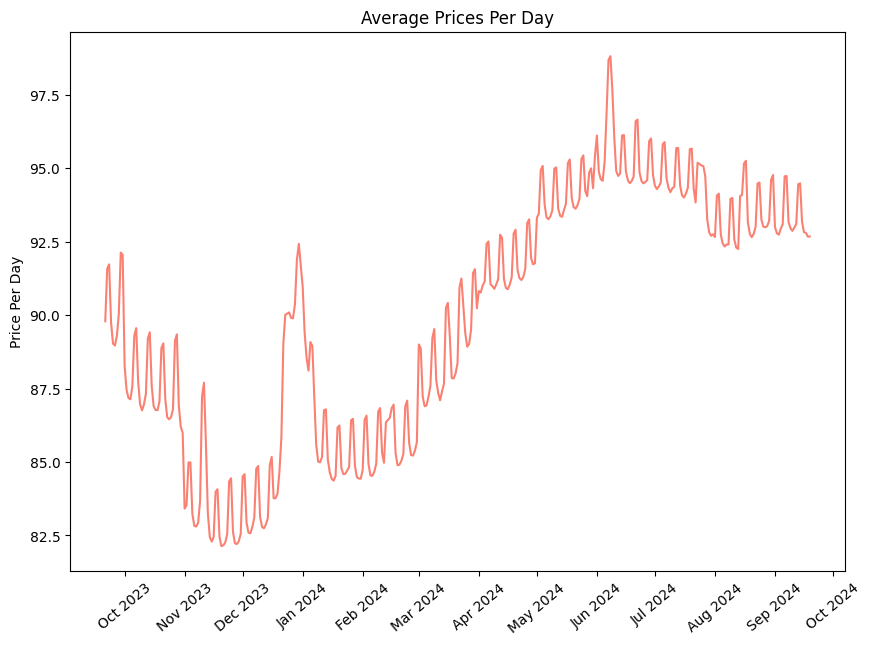

In [44]:
price_per_day.columns = ['date', 'avg price']
price_per_day['date'] = pd.to_datetime(price_per_day['date'])

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(price_per_day['date'], price_per_day['avg price'], color='salmon')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.title('Average Prices Per Day')
# Rotate the x-axis labels for better readability
plt.xticks(rotation=40)
plt.ylabel('Price Per Day')
plt.show()

As we notice the lowest prices are around November (excepct for a peak around the 17th of November again) and December possibly because of the low demand. Again, like the availabilities the first peak is around Christmas time and from March the prices seem to contantly raise with the highest price around June. The local maximum, just like with the availabilities again, could be caused by the weekends.

## Listings per Host

We'll create a table with the number of listings per host, in descending order. 

In [45]:
hosts = listings.groupby('host_id').agg({'id' : ['count']}).reset_index()
hosts.columns = ['host_id', 'no_of_listings' ]
hosts = hosts.sort_values(by='no_of_listings', ascending=False)
hosts

,host_id,no_of_listings
607,20104194,114
2069,113548208,88
1811,90390850,78
60,748818,74
1149,47267002,61
...,...,...
2242,130728079,1
2241,130646248,1
2240,130612477,1
2239,130551473,1


Now let's show in a graph the distribution of listings per host, as follows:

* On the $y$ axis are the number of listings.
That is, a point $(x, y)$ will mean that the $x$-th highest hosting host has $y$ listings.


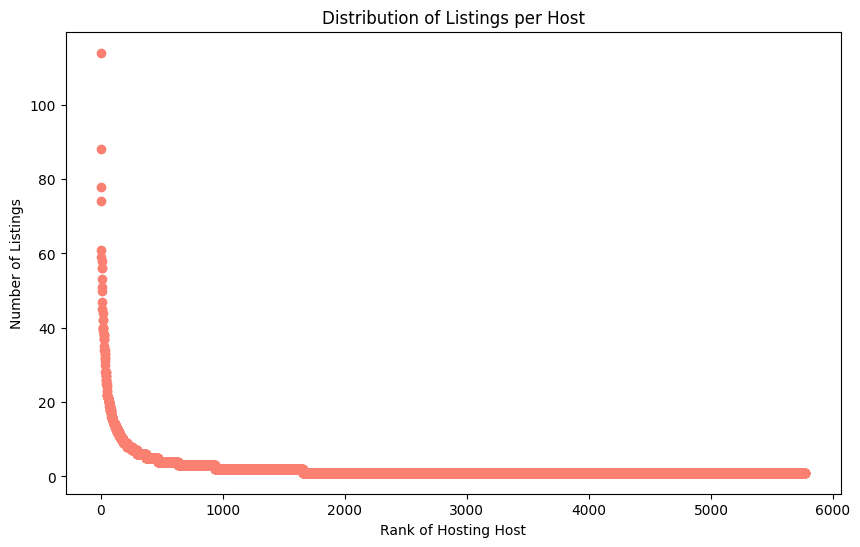

In [46]:
hosts['rank'] = hosts['no_of_listings'].rank(ascending=False, method='first')
plt.figure(figsize=(10, 6))
plt.scatter(hosts['rank'], hosts['no_of_listings'], marker='o', color='salmon')
plt.xlabel('Rank of Hosting Host')
plt.ylabel('Number of Listings')
plt.title('Distribution of Listings per Host')
plt.show()

As we see the first in rank hosts, have *much* higher number of listings than the rest ones, but we can't really see them.
And that's why we'll do another plot, this time with the $x$ axis in logarithmic scale.

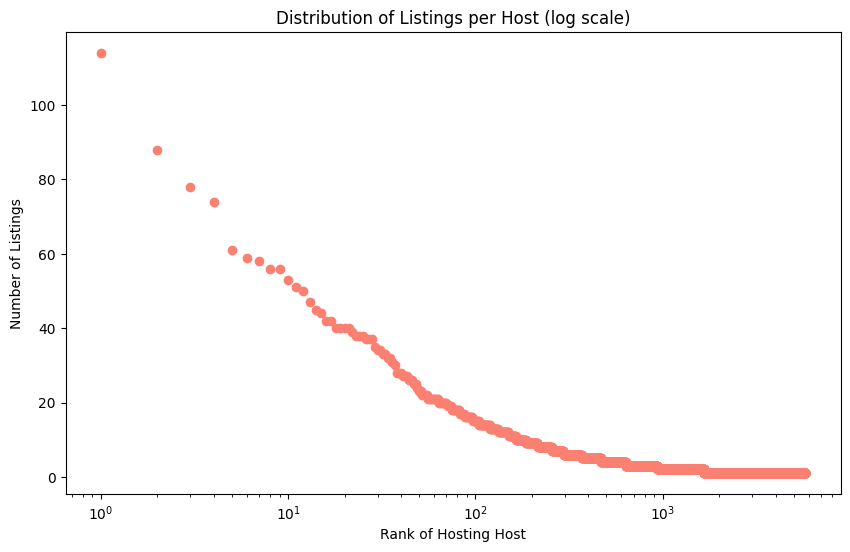

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(hosts['rank'], hosts['no_of_listings'], marker='o', color='salmon')
plt.xlabel('Rank of Hosting Host')
plt.ylabel('Number of Listings')
plt.title('Distribution of Listings per Host (log scale)')
plt.xscale('log')
plt.show()

Now it's much clearer that the top 10 hosts are sparse on the graph with significally higher number of listings. After the 1000th host, the rest 5000 (precisely) have either 1 or 2 listings.

## Visualize Listings

Last but not least, we'll draw an interactive map with folium with all these listings that shows some basic information for each listing.

In [48]:
import folium

In [49]:
points = listings[['room_type','latitude', 'longitude']]
points.loc[:, 'info'] = (
    "<h3><strong>" + listings['name'] + "</strong> by " + listings['host_name'] + "</h3>" +
    listings['neighbourhood_cleansed'] + "<h4>" + listings['price'].astype(str) + "€ / per night</h4>"
)

C:\Users\eugep\AppData\Local\Temp\ipykernel_22440\3482677905.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points.loc[:, 'info'] = (


In [50]:
map = folium.Map(location=[37.9838, 23.7275], zoom_start=13, max_zoom=18, min_zoom=13)

room_type_colors = {
    'Entire home/apt': 'indianred',
    'Private room': 'green',
    'Shared room': 'blue',
    'Hotel room': 'orange'
}

for index, row in points.iterrows():
    circle_marker = folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=room_type_colors.get(row['room_type'], 'gray'),
        fill=True,
        fill_color=room_type_colors.get(row['room_type'], 'gray'),
        fill_opacity=1.0,
    )
        
    circle_marker.add_child(folium.Popup(row['info'], max_width=300)) 
    circle_marker.add_to(map)
    
map.save("listings.html")